In [26]:
import numpy as np
import pandas as pd
import re
import seaborn as sns
data = pd.read_csv("googleplaystore.csv")

def getinstalls(x):
    out = ""
    for i in re.findall(r".*[^+]", x)[0].split(","): out+=i
    print(out)
    print()
    return out


In [27]:
class Preprocessing():
    def __init__(self, data):
        self.data = data

    def dropjunk(self):
        self.data = self.data.drop(["App", "Current Ver", "Last Updated", "Android Ver", "Price", "Content Rating", "Genres"], axis=1)

    def getinstalls(self):
        self.data["Installs"] = self.data["Installs"].apply(lambda a: "".join(re.findall(r".*[^+]", a)[0].split(",")))
        self.data["Installs"] = pd.to_numeric(self.data["Installs"])

    def sizefunc(self):
        self.data["Size"] = self.data["Size"].apply(lambda size: float(size[:-1])*1000 if 'M' in size else (float(size[:-1]) if 'k' in size else None))
        self.data.Size.fillna(method = 'ffill', inplace = True)

    def outlayers(self, field):
        distance = 1.5 * (np.percentile(self.data[field], 75) - np.percentile(self.data[field], 25))
        self.data.drop(self.data[self.data[field] > distance + np.percentile(self.data[field], 75)].index, inplace=True)
        self.data.drop(self.data[self.data[field] < np.percentile(self.data[field], 25) - distance].index, inplace=True)

    def pricer(self):
        self.data["Type"] = self.data["Type"].map(lambda price: 0 if price=="Free" else 1)

    def cleaner(self):
        pass

    def preprocess(self):
        self.dropjunk()
        self.getinstalls()
        self.sizefunc()
        self.outlayers("Size")
        self.data.Installs = np.log(self.data.Installs)
        self.outlayers("Installs")
        self.data.loc[self.data.Installs <= 4, ["Installs"]] = self.data.Installs.median()
        self.data.loc[self.data.Size > 50000, "Size"] = self.data.Size.median()
        self.data.Reviews = np.log(self.data.Reviews)
        self.outlayers("Reviews")
        self.pricer()
        return self.data

preproc = Preprocessing(data)
data = preproc.preprocess()
data = data.dropna()

data


C:\Users\mischa\PycharmProjects\GooglePlay\venv\lib\site-packages\pandas\core\arraylike.py:405: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\mischa\PycharmProjects\GooglePlay\venv\lib\site-packages\pandas\core\arraylike.py:405: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,Category,Rating,Reviews,Size,Installs,Type
0,ART_AND_DESIGN,4.1,5.068904,19000.0,9.210340,0
1,ART_AND_DESIGN,3.9,6.874198,14000.0,13.122363,0
2,ART_AND_DESIGN,4.7,11.379508,8700.0,15.424948,0
3,ART_AND_DESIGN,4.5,12.281384,25000.0,17.727534,0
4,ART_AND_DESIGN,4.3,6.874198,2800.0,11.512925,0
...,...,...,...,...,...,...
10833,FAMILY,4.0,1.945910,2600.0,6.214608,0
10835,FAMILY,4.5,3.637586,12000.0,8.517193,0
10836,FAMILY,5.0,1.386294,3600.0,4.605170,0
10838,BOOKS_AND_REFERENCE,4.5,4.736198,9500.0,6.907755,0


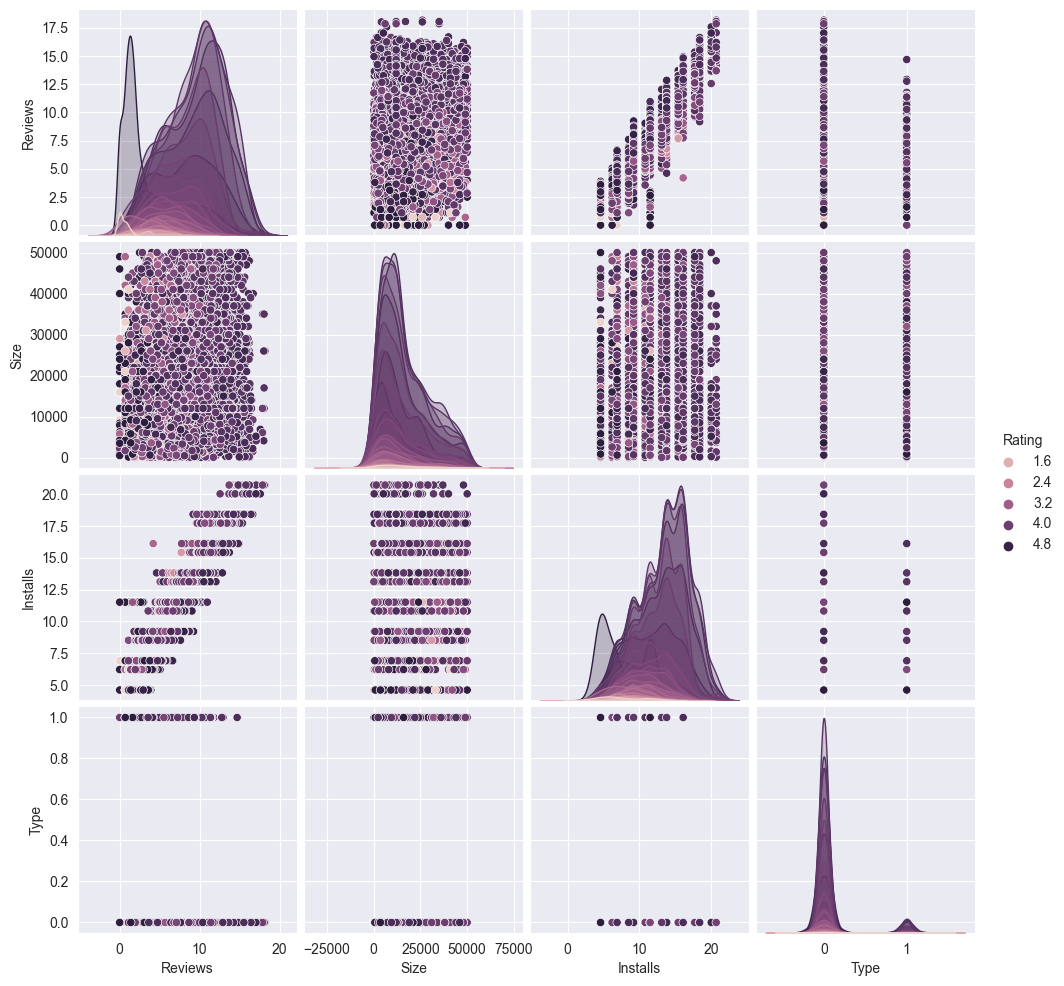

In [28]:
sns.pairplot(data, hue="Rating")

C:\Users\mischa\AppData\Local\Temp\ipykernel_9456\264670479.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data.corr() [["Rating"]].sort_values(by="Rating", ascending=False), cmap="rainbow",vmin=-1, vmax=1, annot=True)


<AxesSubplot: >

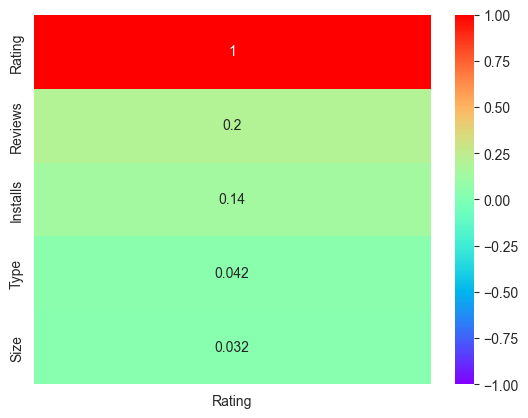

In [29]:
sns.heatmap(data.corr() [["Rating"]].sort_values(by="Rating", ascending=False), cmap="rainbow",vmin=-1, vmax=1, annot=True)

In [30]:
from sklearn.preprocessing import LabelEncoder, StandardScaler, RobustScaler

lbe = LabelEncoder()
data.loc[:, "Category"] = lbe.fit_transform(data.loc[:, "Category"])
data.Category.head(100)

C:\Users\mischa\AppData\Local\Temp\ipykernel_9456\1981012603.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[:, "Category"] = lbe.fit_transform(data.loc[:, "Category"])
C:\Users\mischa\AppData\Local\Temp\ipykernel_9456\1981012603.py:4: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data.loc[:, "Category"] = lbe.fit_transform(data.loc[:, "Category"])


0      0
1      0
2      0
3      0
4      0
      ..
96     1
97     1
98     2
99     2
100    2
Name: Category, Length: 100, dtype: int32

In [31]:
data.Category.value_counts()

11    1541
14     838
29     729
25     346
20     333
6      326
24     314
12     310
23     309
18     306
4      301
28     293
15     286
27     237
26     237
21     230
30     212
7      192
3      174
31     156
8      147
9      144
19     121
13     108
32      75
16      73
1       71
17      63
0       62
5       58
22      47
10      45
2       42
Name: Category, dtype: int64

In [32]:
data.Category = data.Category.astype("category")

C:\Users\mischa\AppData\Local\Temp\ipykernel_9456\520251225.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.Category = data.Category.astype("category")


In [33]:
data.Type = data.Type.astype("category")

C:\Users\mischa\AppData\Local\Temp\ipykernel_9456\4269236192.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.Type = data.Type.astype("category")


In [34]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8726 entries, 0 to 10839
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   Category  8726 non-null   category
 1   Rating    8726 non-null   float64 
 2   Reviews   8726 non-null   float64 
 3   Size      8726 non-null   float64 
 4   Installs  8726 non-null   float64 
 5   Type      8726 non-null   category
dtypes: category(2), float64(4)
memory usage: 359.3 KB


array([[<AxesSubplot: title={'center': 'Rating'}>,
        <AxesSubplot: title={'center': 'Reviews'}>],
       [<AxesSubplot: title={'center': 'Size'}>,
        <AxesSubplot: title={'center': 'Installs'}>]], dtype=object)

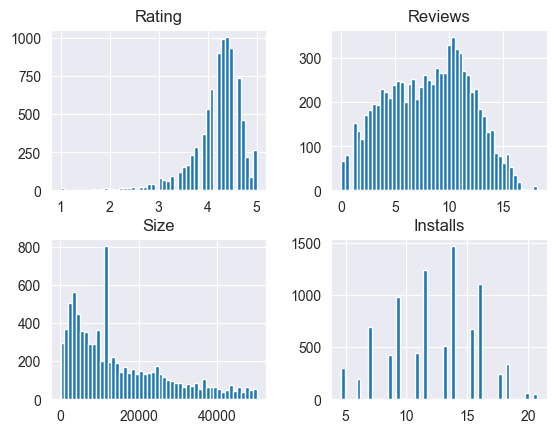

In [35]:
data.hist(bins=50)


<AxesSubplot: >

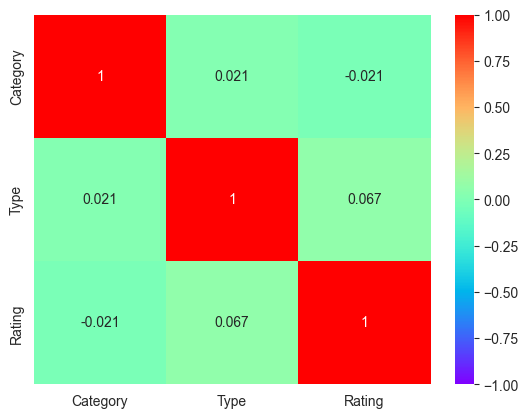

In [36]:
categ = data.loc[:,["Category", "Type", "Rating"]]
sns.heatmap(categ.corr(method="spearman", numeric_only=False), cmap="rainbow", vmin=-1, vmax=1, annot=True)


In [37]:
y = pd.DataFrame(data.Rating)
x = data.drop(["Rating"], axis=1)
x.head()

,Category,Reviews,Size,Installs,Type
0,0,5.068904,19000.0,9.210340,0
1,0,6.874198,14000.0,13.122363,0
2,0,11.379508,8700.0,15.424948,0
3,0,12.281384,25000.0,17.727534,0
4,0,6.874198,2800.0,11.512925,0


In [52]:
sscaler = StandardScaler()
rscaler = RobustScaler()



x = pd.DataFrame(sscaler.fit_transform(x))
y = pd.DataFrame(sscaler.fit_transform(y))
x

,0,1,2,3,4
0,-2.012719,-0.807576,0.283743,-0.838675,-0.274878
1,-2.012719,-0.336311,-0.111398,0.234748,-0.274878
2,-2.012719,0.839782,-0.530247,0.866556,-0.274878
3,-2.012719,1.075213,0.757912,1.498364,-0.274878
4,-2.012719,-0.336311,-0.996513,-0.206867,-0.274878
...,...,...,...,...,...
8721,-0.706082,-1.622822,-1.012318,-1.660676,-0.274878
8722,-0.706082,-1.181216,-0.269454,-1.028868,-0.274878
8723,-0.706082,-1.768907,-0.933290,-2.102291,-0.274878
8724,-1.656364,-0.894428,-0.467024,-1.470483,-0.274878


array([[<AxesSubplot: title={'center': 'Rating'}>,
        <AxesSubplot: title={'center': 'Reviews'}>],
       [<AxesSubplot: title={'center': 'Size'}>,
        <AxesSubplot: title={'center': 'Installs'}>]], dtype=object)

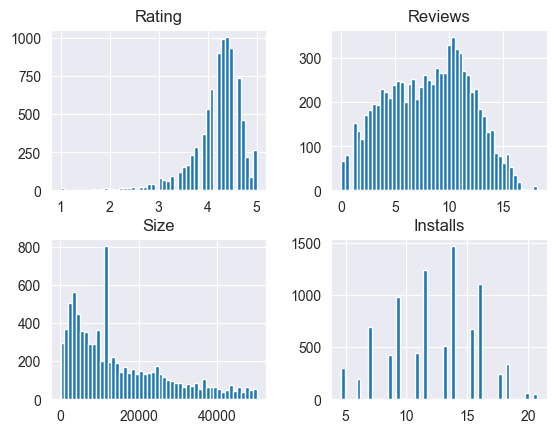

In [39]:
data.hist(bins=50)

In [40]:

from sklearn.model_selection import train_test_split

y.head()

,0
0,-0.160638
1,-0.542998
2,0.986440
3,0.604081
4,0.221721


In [41]:
x.head()

,0,1,2,3,4
0,-2.012719,-0.807576,0.283743,-0.838675,-0.274878
1,-2.012719,-0.336311,-0.111398,0.234748,-0.274878
2,-2.012719,0.839782,-0.530247,0.866556,-0.274878
3,-2.012719,1.075213,0.757912,1.498364,-0.274878
4,-2.012719,-0.336311,-0.996513,-0.206867,-0.274878


In [42]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=True, random_state=42)
y_train.head()

,0
31,0.604081
3002,0.604081
3887,0.030541
4071,0.030541
3428,-0.925358


In [43]:
from sklearn.linear_model import LinearRegression
linreg = LinearRegression()
model = linreg.fit(x_train, y_train)
predict = linreg.predict(x_test)
predict

array([[ 0.16811598],
       [ 0.30069725],
       [-0.21800896],
       ...,
       [ 0.01412594],
       [-0.20786888],
       [ 0.24071455]])

In [46]:
y_test

,0
1057,0.221721
8115,1.177620
3992,0.412901
3418,0.221721
5111,0.412901
...,...
7279,-0.351818
7684,0.412901
4353,-0.925358
2644,-0.160638


In [49]:

linreg.score(x_test, y_test)

0.07616487522828053

In [51]:
from sklearn.model_selection import cross_val_score
cross_val_score(linreg, x, y, scoring="accuracy", cv=3)

C:\Users\mischa\PycharmProjects\GooglePlay\venv\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\mischa\PycharmProjects\GooglePlay\venv\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\mischa\PycharmProjects\GooglePlay\venv\lib\site-packages\sklearn\metrics\_scorer.py", line 106, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\mischa\PycharmProjects\GooglePlay\venv\lib\site-packages\sklearn\metrics\_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\mischa\PycharmProjects\GooglePlay\venv\lib\site-packages\sklearn\metrics\_classification.py", line 211, in accuracy_score
    y_type, y_true, y_pred 

array([nan, nan, nan])